# This is my science fair project

In [1]:
cifar10_dir='cifar-10-batches-py'

In [2]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
# Setting up the environment
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

In [4]:
# Function to load a batch into memory
def load_batch(data_dir, batch_id):
    with open(os.path.join(cifar10_dir, 'data_batch_%i' % batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
    feats = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    lbls = batch['labels']
    return feats, lbls

In [5]:
# and load the first batch
feats, labels = load_batch(cifar10_dir, 1)

Label Id: 7 - Class: horse


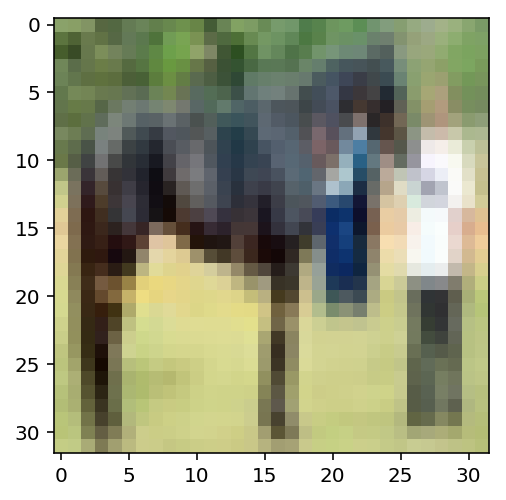

In [6]:
sample_id = 9505
sample_img = feats[sample_id]
sample_lbl = labels[sample_id]
print('Label Id: {} - Class: {}'.format(sample_lbl, label_names[sample_lbl]))
plt.imshow(sample_img)

In [7]:
# some stats
print([sample_img.min(), sample_img.max(), sample_img.shape])

[1, 254, (32, 32, 3)]


In [8]:
def normalize(x):
    return x / 255.

In [9]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer().fit(range(10))

def one_hot_encode(x):
    global lb
    return lb.transform(x)

In [10]:
test_feats, test_lbls = [], []

In [11]:
for i in range(1, 6):
    feats, lbls = load_batch(cifar10_dir, i)
    test_size = int(len(feats) * 0.1)
    
    # training data
    norm_feats = normalize(feats[:-test_size])
    one_hot_lbls = one_hot_encode(lbls[:-test_size])
    pickle.dump((norm_feats, one_hot_lbls), open('preprocess_batch_%i.p' % i, 'wb'))
    
    # add the rest to the test data
    test_feats.extend(feats[-test_size:])
    test_lbls.extend(lbls[-test_size:])

# dump the test data too
norm_test_feats = normalize(np.array(test_feats))
one_hot_test_lbls = one_hot_encode(np.array(test_lbls))
pickle.dump((norm_test_feats, one_hot_test_lbls), open('preprocess_test.p', 'wb'))


In [12]:
import tensorflow as tf

In [13]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    # Weights
    W_shape = list(conv_ksize) + [int(x_tensor.shape[3]), conv_num_outputs]
    W = tf.Variable(tf.truncated_normal(W_shape, stddev=.05))
    
    # Apply convolution
    x = tf.nn.conv2d(
        x_tensor, W,
        strides = [1] + list(conv_strides) + [1],
        padding = 'SAME'
    )
    
    # Add bias
    b = tf.Variable(tf.zeros([conv_num_outputs]))
    x = tf.nn.bias_add(x, b)
    
    # Nonlinear activation (ReLU)
    x = tf.nn.relu(x)
    
    # Max pooling
    return tf.nn.m pool(
        x,
        ksize = [1] + list(pool_ksize) + [1],
        strides = [1] + list(pool_strides) + [1],
        padding = 'SAME'
    )

In [14]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    return tf.reshape(x_tensor, [-1, np.prod(x_tensor.shape.as_list()[1:])])

In [15]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # Weights and bias
    W = tf.Variable(tf.truncated_normal([int(x_tensor.shape[1]), num_outputs], stddev=.05))
    b = tf.Variable(tf.zeros([num_outputs]))
    
    # The fully connected layer
    x = tf.add(tf.matmul(x_tensor, W), b)
    
    # ReLU activation function
    return tf.nn.relu(x)

In [16]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # Weights and bias
    W = tf.Variable(tf.truncated_normal([int(x_tensor.shape[1]), num_outputs], stddev=.05))
    b = tf.Variable(tf.zeros([num_outputs]))
    
    # The output layer
    return tf.add(tf.matmul(x_tensor, W), b)

In [17]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # 3 convolution layers with max pooling
    # All layers with same kernel, stride and maxpooling params
    x = conv2d_maxpool(x, 64, (3,3), (1,1), (2,2), (2,2))
    x = conv2d_maxpool(x, 128, (3,3), (1,1), (2,2), (2,2))
    x = conv2d_maxpool(x, 256, (3,3), (1,1), (2,2), (2,2))
    
    # dropout after convolutions
    x = tf.nn.dropout(x, keep_prob)
    
    # flatten layer
    x = flatten(x)

    # 1 fully connected layer followed by dropout
    x = fully_conn(x, 1024)
    x = tf.nn.dropout(x, keep_prob)
    
    # output layer
    return output(x, 10)

In [18]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = tf.placeholder(tf.float32, [None, 32, 32, 3], name="x")
y = tf.placeholder(tf.float32, [None, 10], name="y")
keep_prob = tf.placeholder(tf.float32, name="keep_prob")

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [19]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    global valid_features, valid_labels
    loss = sess.run(cost, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.})
    valid_acc = sess.run(
        accuracy, 
        feed_dict={
            x: norm_test_feats,
            y: one_hot_test_lbls,
            keep_prob: 1.
        }
    )
    print('Loss: {:>8.4f}, Validation Accuracy: {:>8.6f}'.format(loss, valid_acc))

In [20]:
epochs = 80
batch_size = 1024
keep_probability = 0.5

In [21]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]


def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)

In [22]:
print("Training...")
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        n_batches = 5
        for batch_i in range(1, n_batches+1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                sess.run(
                    optimizer, 
                    feed_dict={
                        x: batch_features, 
                        y: batch_labels, 
                        keep_prob: keep_probability
                    }
                )
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
    
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, './image_classification')

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:   2.1852, Validation Accuracy: 0.238400
Epoch  1, CIFAR-10 Batch 2:  Loss:   1.9302, Validation Accuracy: 0.324000
Epoch  1, CIFAR-10 Batch 3:  Loss:   1.8220, Validation Accuracy: 0.331200
Epoch  1, CIFAR-10 Batch 4:  Loss:   1.7094, Validation Accuracy: 0.362200
Epoch  1, CIFAR-10 Batch 5:  Loss:   1.5995, Validation Accuracy: 0.417400
Epoch  2, CIFAR-10 Batch 1:  Loss:   1.5199, Validation Accuracy: 0.443400
Epoch  2, CIFAR-10 Batch 2:  Loss:   1.4819, Validation Accuracy: 0.464200
Epoch  2, CIFAR-10 Batch 3:  Loss:   1.3456, Validation Accuracy: 0.482800
Epoch  2, CIFAR-10 Batch 4:  Loss:   1.3631, Validation Accuracy: 0.502000
Epoch  2, CIFAR-10 Batch 5:  Loss:   1.2991, Validation Accuracy: 0.514400
Epoch  3, CIFAR-10 Batch 1:  Loss:   1.2870, Validation Accuracy: 0.528600
Epoch  3, CIFAR-10 Batch 2:  Loss:   1.3077, Validation Accuracy: 0.514400
Epoch  3, CIFAR-10 Batch 3:  Loss:   1.1733, Validation Accuracy: 0.546800
Epoch  3, CIF

Epoch 22, CIFAR-10 Batch 5:  Loss:   0.2565, Validation Accuracy: 0.773400
Epoch 23, CIFAR-10 Batch 1:  Loss:   0.3031, Validation Accuracy: 0.781200
Epoch 23, CIFAR-10 Batch 2:  Loss:   0.2516, Validation Accuracy: 0.782200
Epoch 23, CIFAR-10 Batch 3:  Loss:   0.2411, Validation Accuracy: 0.790000
Epoch 23, CIFAR-10 Batch 4:  Loss:   0.2871, Validation Accuracy: 0.774000
Epoch 23, CIFAR-10 Batch 5:  Loss:   0.2487, Validation Accuracy: 0.782200
Epoch 24, CIFAR-10 Batch 1:  Loss:   0.2852, Validation Accuracy: 0.785000
Epoch 24, CIFAR-10 Batch 2:  Loss:   0.2618, Validation Accuracy: 0.779200
Epoch 24, CIFAR-10 Batch 3:  Loss:   0.2239, Validation Accuracy: 0.787800
Epoch 24, CIFAR-10 Batch 4:  Loss:   0.2246, Validation Accuracy: 0.794600
Epoch 24, CIFAR-10 Batch 5:  Loss:   0.1912, Validation Accuracy: 0.793600
Epoch 25, CIFAR-10 Batch 1:  Loss:   0.2444, Validation Accuracy: 0.791800
Epoch 25, CIFAR-10 Batch 2:  Loss:   0.2272, Validation Accuracy: 0.787800
Epoch 25, CIFAR-10 Batch 

Epoch 44, CIFAR-10 Batch 4:  Loss:   0.0413, Validation Accuracy: 0.814400
Epoch 44, CIFAR-10 Batch 5:  Loss:   0.0357, Validation Accuracy: 0.815200
Epoch 45, CIFAR-10 Batch 1:  Loss:   0.0419, Validation Accuracy: 0.811400
Epoch 45, CIFAR-10 Batch 2:  Loss:   0.0369, Validation Accuracy: 0.805200
Epoch 45, CIFAR-10 Batch 3:  Loss:   0.0523, Validation Accuracy: 0.815600
Epoch 45, CIFAR-10 Batch 4:  Loss:   0.0368, Validation Accuracy: 0.817800
Epoch 45, CIFAR-10 Batch 5:  Loss:   0.0326, Validation Accuracy: 0.815600
Epoch 46, CIFAR-10 Batch 1:  Loss:   0.0393, Validation Accuracy: 0.814200
Epoch 46, CIFAR-10 Batch 2:  Loss:   0.0389, Validation Accuracy: 0.803000
Epoch 46, CIFAR-10 Batch 3:  Loss:   0.0416, Validation Accuracy: 0.818200
Epoch 46, CIFAR-10 Batch 4:  Loss:   0.0388, Validation Accuracy: 0.809400
Epoch 46, CIFAR-10 Batch 5:  Loss:   0.0291, Validation Accuracy: 0.812400
Epoch 47, CIFAR-10 Batch 1:  Loss:   0.0371, Validation Accuracy: 0.814000
Epoch 47, CIFAR-10 Batch 

Epoch 66, CIFAR-10 Batch 3:  Loss:   0.0091, Validation Accuracy: 0.815800
Epoch 66, CIFAR-10 Batch 4:  Loss:   0.0070, Validation Accuracy: 0.823200
Epoch 66, CIFAR-10 Batch 5:  Loss:   0.0092, Validation Accuracy: 0.811800
Epoch 67, CIFAR-10 Batch 1:  Loss:   0.0070, Validation Accuracy: 0.819400
Epoch 67, CIFAR-10 Batch 2:  Loss:   0.0084, Validation Accuracy: 0.810200
Epoch 67, CIFAR-10 Batch 3:  Loss:   0.0080, Validation Accuracy: 0.819000
Epoch 67, CIFAR-10 Batch 4:  Loss:   0.0068, Validation Accuracy: 0.817200
Epoch 67, CIFAR-10 Batch 5:  Loss:   0.0068, Validation Accuracy: 0.821800
Epoch 68, CIFAR-10 Batch 1:  Loss:   0.0071, Validation Accuracy: 0.814600
Epoch 68, CIFAR-10 Batch 2:  Loss:   0.0083, Validation Accuracy: 0.812600
Epoch 68, CIFAR-10 Batch 3:  Loss:   0.0081, Validation Accuracy: 0.821200
Epoch 68, CIFAR-10 Batch 4:  Loss:   0.0061, Validation Accuracy: 0.820400
Epoch 68, CIFAR-10 Batch 5:  Loss:   0.0053, Validation Accuracy: 0.819000
Epoch 69, CIFAR-10 Batch 

In [ ]:
import tensorflow as tf
import pickle
import random
import numpy as np

In [ ]:
model_path = './image_classification'
n_sample = 4
top_n_predictions = 3

In [ ]:
test_features, test_labels = pickle.load(open('preprocessing_test.p', mode='rb'))
loaded_graph = tf.Graph()


In [ ]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

In [ ]:
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])

In [ ]:
with tf.Session(graph=loaded_graph) as sess:
    # Load model
    loader = tf.train.import_meta_graph(model_path + '.meta')
    loader.restore(sess, model_path)

    # Get Tensors from loaded model
    loaded_x = loaded_graph.get_tensor_by_name('x:0')
    loaded_y = loaded_graph.get_tensor_by_name('y:0')
    loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
    loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
    loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
    # Get accuracy in batches for memory limitations
    test_batch_acc_total = 0
    test_batch_count = 0
    
    for test_feature_batch, test_label_batch in batch_features_labels(test_features, test_labels, batch_size):
        test_batch_acc_total += sess.run(
            loaded_acc,
            feed_dict={
                loaded_x: test_feature_batch, 
                loaded_y: test_label_batch, 
                loaded_keep_prob: 1.0
            }
        )
        test_batch_count += 1

    print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

    # Print Random Samples
    random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
    random_test_predictions = sess.run(
        tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
        feed_dict={
            loaded_x: random_test_features, 
            loaded_y: random_test_labels, 
            loaded_keep_prob: 1.0
        }
    )
    display_image_predictions(random_test_features, random_test_labels, random_test_predictions)
